<a href="https://colab.research.google.com/github/delhian/funny-tasks/blob/main/time_series_and_predicted_interval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from datetime import date, datetime, timedelta
from matplotlib.animation import FuncAnimation
from sklearn.linear_model import QuantileRegressor, LinearRegression

In [ ]:
ls ./30112021

Small_Files_nine_months.jpg         Small_Files_three_months.jpg
Small_Files_nine_months_data.xlsx   Small_Files_three_months_data.xlsx
Small_Files_six_months.jpg          Small_Files_two_weeks.jpg
Small_Files_six_months_data.xlsx    Small_Files_two_weeks_data.xlsx


In [ ]:
files = ['Small_Files_nine_months_data.xlsx',
         'Small_Files_six_months_data.xlsx',
         'Small_Files_three_months_data.xlsx',
         'Small_Files_two_weeks_data.xlsx']

df = pd.read_excel(io = os.path.join(r'./30112021', files[0]),  parse_dates = ['Time'], ) 
df = df.fillna(0)

df = df.set_index('Time')

In [ ]:
col_internal = [x for x in df.columns if '/data/core/internal' in x.lower()]

y = []

for ind, col in enumerate(df.columns):
    downsampled = df[[col]].resample('1D').fillna(method = 'bfill')
    if ind == 0:
        df_new = downsampled.drop(columns = col)
    y.append(downsampled[col].values.tolist())
    df_new[col] = downsampled
    
x = downsampled.index

df = df_new
    
del df_new

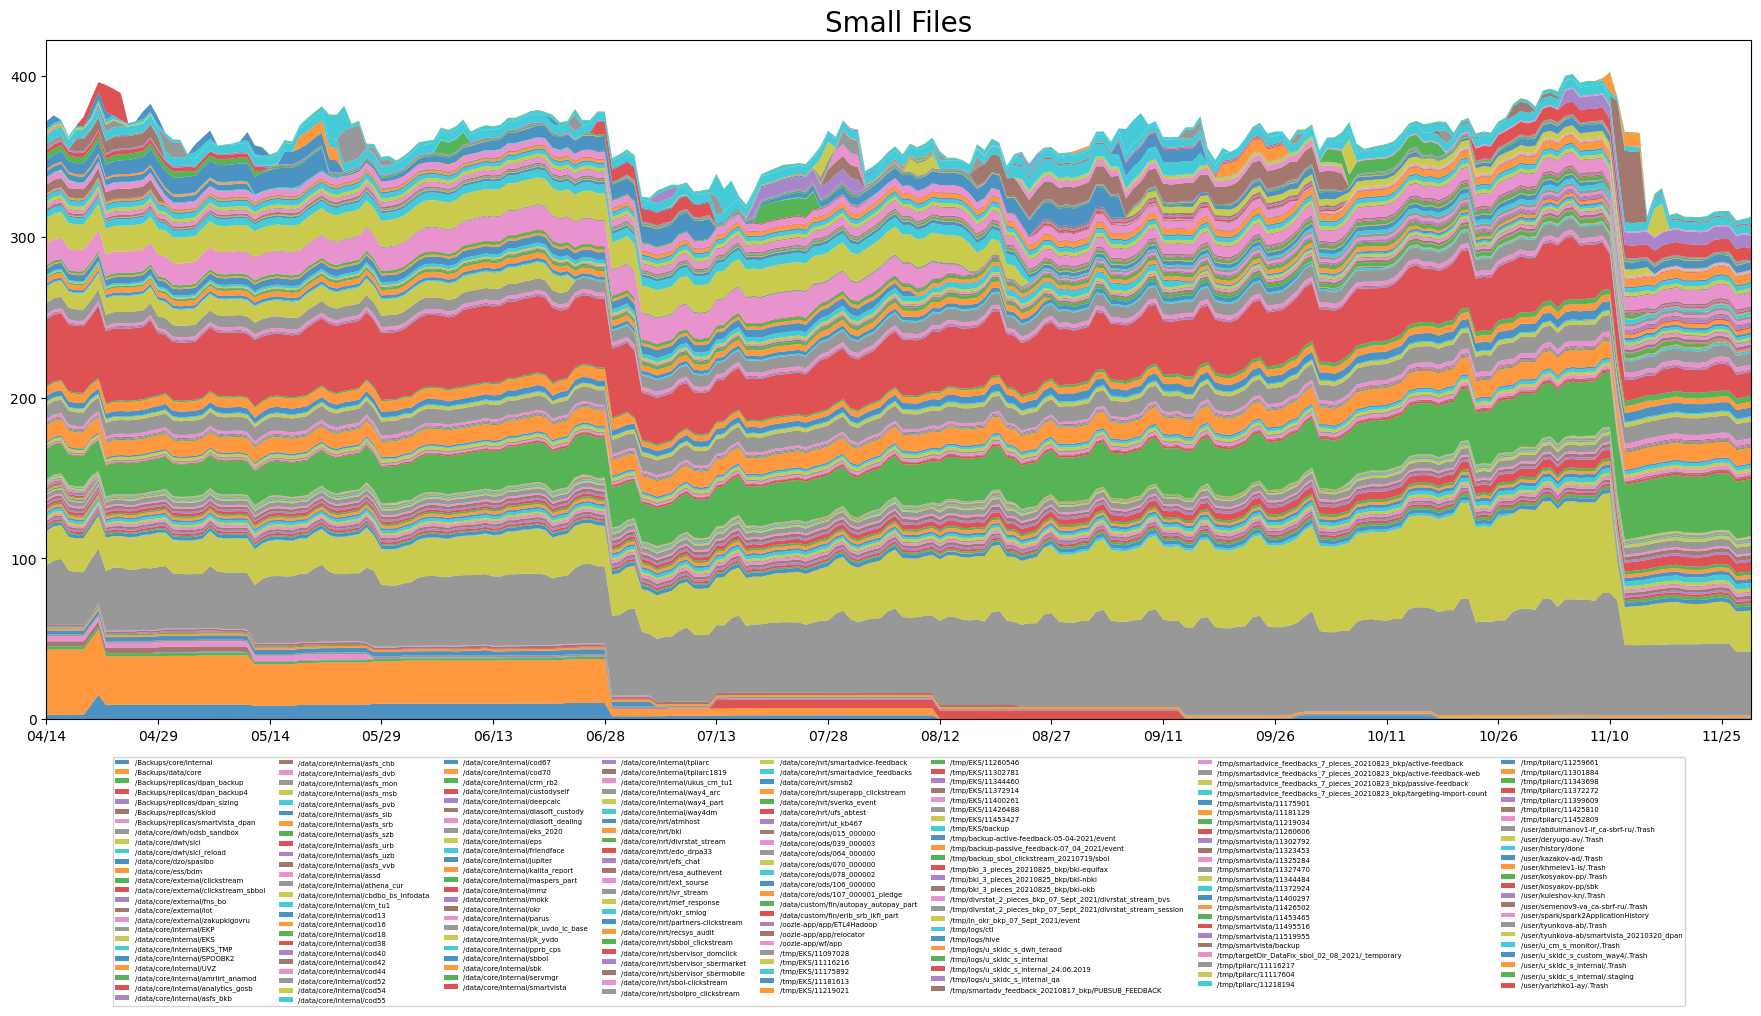

                                replica   min   max  current
0               /data/core/internal/EKP  32.7  76.2     39.7
1           /data/core/internal/crm_rb2  18.6  35.6     35.6
2               /data/core/internal/EKS  19.7  64.6     25.6
3        /data/core/internal/smartvista  12.3  47.8     14.8
4   /data/core/internal/pk_uvdo_lc_base   8.5  10.5     10.5
5     /data/core/internal/kalita_report   9.3  10.6      9.7
6             /data/core/ods/039_000003   2.0   8.5      8.5
7              /tmp/smartvista/11519955   0.0   7.9      7.9
8              /tmp/smartvista/11495516   0.0   7.9      7.9
9          /data/core/internal/way4_arc   7.2   7.2      7.2
10         /data/core/internal/asfs_urb   1.2   6.1      6.1
11            /data/core/internal/sbbol   2.9   5.6      5.5
12                   /user/history/done   4.7   5.9      5.3
13     /data/core/ods/107_000001_pledge   1.0   4.9      4.9
14                       /tmp/logs/hive   0.0  13.5      4.8
15          /user/u_cm_s

In [ ]:

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(22, 9), dpi= 100)

ax = plt.gca()
ax.stackplot(x, y, labels=df.columns, alpha=0.8)

ax.set_title('Small Files', fontsize=20)

plt.xticks(x[::15], fontsize=10, horizontalalignment='center')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

values = np.arange(0, 500, 100)
value_increment = 1000000

plt.yticks(values * value_increment, ['%d' % val for val in values], fontsize=10)
plt.xlim(x[0], x[-1])


ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=False, ncol=8, fontsize = 5)

plt.show()

results = pd.melt(df,value_vars=df.columns).groupby('variable')\
.agg({'value':['min', 'max', 'last']}).reset_index()

results.columns = ['replica', 'min', 'max', 'current']
million = 1000000
results['min'] = results['min']/million
results['max'] = results['max']/million
results['current'] = results['current']/million
results = round(results, 1)
results = results.sort_values(['current'], ascending = False).reset_index(drop=True)

print(results[:20])

In [ ]:
    def _get_predicted_interval(lst, days_before, days_forecast, n):
#        Naïve forecasts  см. : https://otexts.com/fpp2/prediction-intervals.html
        # Prediction interval -> z
        # 75%	1.15
        # 90%	1.64
        # 95%	1.96
        # 99%	2,326
        def get_polinominal_f(l):
            l = np.array(l)
            for i in range(2, n + 1):
                l = np.vstack([l, [x**i for x in l]])
            if n == 1:
                return l.T.reshape(-1,1)
            return l.T

        z = 1.96
        x = list(range(len(lst)))
#         print(x)
        x_days_before = x[-days_before:]
#         print(x_days_before)
        lst_days_before = lst[-days_before:]
#         print(lst_days_before)
        x_forecast = np.array(range(x_days_before[0], x[-1] + days_forecast + 1))
#         print(x_forecast)
#         Ограничиваемся полиномом n - степени:
        x_days_before_polinom = get_polinominal_f(x_days_before)
#         print(x_days_before_polinom.shape)
#         return x_days_before_polinom
#         x_days_before_polinom = x_days_before_polinom.reshape(-1, 1)
        clf = LinearRegression().fit(x_days_before_polinom, lst_days_before)
        
#         Остатки:
        resideals = [x - y for x, y in zip(lst_days_before, clf.predict(x_days_before_polinom))]
#         Несмещенное стандартное отклонение:   
        s = np.std(resideals, ddof = 1)
    
# Пресказываем на x_forecast - шагов
        forecasts = clf.predict(get_polinominal_f(x_forecast))
        forecasts_upper = [t + s * z * (index + 1) ** 0.5 for index, t in enumerate(forecasts[-days_forecast:])]
        forecasts_lower = [t - s * z * (index + 1) ** 0.5 for index, t in enumerate(forecasts[-days_forecast:])]
        new_dates = pd.DatetimeIndex([lst_days_before.index[-1] + timedelta(days = t + 1) for t in range(days_forecast)])

        return lst_days_before.index.append(new_dates), forecasts, new_dates, forecasts_lower, forecasts_upper


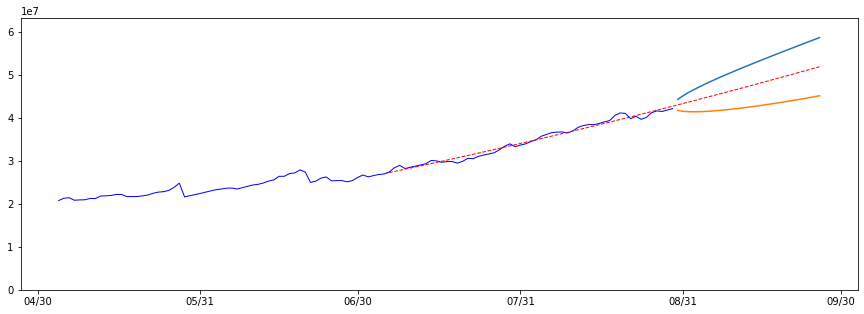

In [ ]:
replica = '/data/core/internal/EKS'
# replica = '/data/core/internal/EKP'

# replica = '/data/core/internal/athena_cur'
# replica = '/data/core/internal/crm_rb2'

# replica = '/data/core/ods/039_000003'
# replica = '/data/core/internal/smartvista'

days_forecast = 7*4
days_before = 8*7

start_date, end_date = '2021-05-05' , '2021-08-30'

d = df[start_date: end_date ][replica]

plt.figure(figsize = (15, 5))
plt.ylim([0, d.max()*1.5])
plt.plot(d, lw=1, c= 'blue')

dates, forecasts, new_dates, forecasts_lower, forecasts_upper = \
_get_predicted_interval(d, days_before, days_forecast, 2)

plt.plot(dates, forecasts, lw=1, c= 'red', linestyle='dashed')

plt.plot(new_dates, forecasts_upper)
plt.plot(new_dates, forecasts_lower,)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# plt.title(replica, fontsize = 16)

In [ ]:
# %matplotlib inline

%matplotlib notebook

class Scope:
    def __init__(self, df, ax, start_date, end_date, days_forecast, days_before_init, polinom_n):
        self.polinom_n = polinom_n
        self.ax = ax
        self.coverage = []
        self.wmape = []
        self.df = df[start_date: end_date]
        self.start_x = min(self.df[start_date: end_date].index)
        self.end_x = max(self.df[start_date: end_date].index)
        self.start_y = self.df[self.start_x:self.start_x].values[0]
        self.min_y = self.df[start_date: end_date].min()
        self.max_y = self.df[start_date: end_date].max()
        self.days_forecast = days_forecast
        self.days_before_init = days_before_init
        self.days_before = self.days_before_init
        self.x = [self.start_x]
#         ПРОГНОЗИРУЕМЫЙ ПЕРИОД self.days_forecast:
        self.x_forecast = [self.start_x + timedelta(days = 1 + x) for x in range(self.days_forecast)]
        self.y = [self.start_y]
        self.y_predicted_lower = [self.start_y] * self.days_forecast
        self.y_predicted = self.y_predicted_lower
        self.y_predicted_upper = self.y_predicted_lower
        self.y_2 = [0]    
        self.line = Line2D(self.x,
                           self.y,
                           marker ='.',
#                                  linestyle='dotted',
                           color ='blue',
                           markersize=.5)
        self.line_predicted_lower = Line2D(self.x_forecast,
                                 self.y_predicted_lower,
                                 marker ='.',
                                 linestyle='dotted',
                                 color ='orange',
                                 markersize=.1)
        self.line_predicted = Line2D(self.x_forecast,
                                 self.y_predicted,
                                 marker ='.',
                                 linestyle='dotted',
                                 color ='green',
                                 markersize=.1)
        self.line_predicted_upper = Line2D(self.x_forecast,
                                 self.y_predicted_upper,
                                 marker ='.',
                                 linestyle='dotted',
                                 color ='orange',
                                 markersize=.1)

        self.ax.set_ylim(0, self.max_y *1.1)
        self.ax.set_xlim(self.start_x, self.end_x)   
        self.ax.add_line(self.line)
        self.ax.add_line(self.line_predicted)
        self.ax.add_line(self.line_predicted_lower)
        self.ax.add_line(self.line_predicted_upper)
        
    def _get_polinominal_f(self, l):
        l = np.array(l)
        for i in range(2, self.polinom_n + 1):
            l = np.vstack([l, [x**i for x in l]])
        if self.polinom_n == 1:
            return l.T.reshape(-1,1)
        return l.T

    def _get_predicted_interval(self, lst):
#        Naïve forecasts  см. : https://otexts.com/fpp2/prediction-intervals.html
        # Prediction interval -> z
        # 75%	1.15
        # 90%	1.64
        # 95%	1.96
        # 99%	2,326
        z = 1.64
        x = list(range(-self.days_forecast, len(lst)))[-self.days_before:]
        lst_ = ([lst[0]]*self.days_forecast + lst)[-self.days_before:]
        x_forecast = np.array(range(x[-1] + 1, x[-1] + self.days_forecast + 1))

        
        x_poly_x = self._get_polinominal_f(x)
        clf = LinearRegression().fit(x_poly_x, lst_)   
        
        
#         Ограничиваемся полиномом 2 степени:
#         poly_x = [x * x for x in x]
#         x_poly_x = np.stack([x, poly_x]).T
        
#         clf = LinearRegression().fit(x_poly_x, lst_)
# Пресказываем на x_forecast - шагов

        forecasts = clf.predict(self._get_polinominal_f(x_forecast)).tolist()
        
#         Остатки:
        resideals = [x - y for x, y in zip(lst_, clf.predict(x_poly_x))]
#         Несмещенное стандартное отклонение:   
        s = np.std(resideals, ddof = 1)
#         forecasts_upper = [clf.intercept_ + t * clf.coef_[0] + clf.coef_[1] * t * t + \
#                            s * z * (index + 1) ** 0.5 for index, t in enumerate(x_forecast)]
#         forecasts_lower  = [clf.intercept_ + t * clf.coef_[0] + clf.coef_[1] * t * t - \
#                             s * z * (index + 1) ** 0.5 for index, t in enumerate(x_forecast)]
        forecasts_upper = [t + s * z * (index + 1) ** 0.5 for index, t in enumerate(forecasts)]
        forecasts_lower = [t - s * z * (index + 1) ** 0.5 for index, t in enumerate(forecasts)]
        
        return forecasts_lower, forecasts, forecasts_upper

    
    def update(self, y):
        if self.x[-1] > self.end_x:
            self.coverage = []
            self.x = [self.start_x]
            self.x_forecast = [self.start_x + timedelta(days = 1 + x) for x in range(self.days_forecast)]
            self.y = [self.start_y]
            self.y_predicted_lower = [self.start_y] * self.days_forecast
            self.y_predicted = self.y_predicted_lower
            self.y_predicted_upper = self.y_predicted_lower
            self.ax.set_xlim(self.start_x, self.end_x)
#         СМЕЩАЕМСЯ НА 1 СУТКИ:
        self.x.append(self.x[-1] + timedelta(days=1))
#         СМЕЩАЕМ ПЕРИОД ПРЕДСКАЗАНИЯ НА 1 СУТКИ:
        self.x_forecast = self.x_forecast + [self.x_forecast[-1] + timedelta(days=1)]
        y = self.df[self.x[-1].strftime(date_format)]
        self.y.append(y)
        flag = 2 * abs(self.y[-1] - self.y[-2]) /(self.y[-1] + self.y[-2])
        flag = round(100 * flag, 0)
#      ЕСЛИ ПРОИСХОДИТ СИЛЬНЫЙ СКАЧОК "ВОЗРАЩАЕМСЯ В НАЧАЛО" 
        if flag > 10:
            self.days_before = 0
            ax.set_title(f'Cпад на {flag}% !', fontsize = 7 , loc = 'right')

        if self.days_before < self.days_before_init:
            self.days_before += 1
#      ПОЛУЧАЕМ ПРЕДСКАЗАНИЯ НА ПЕРИОД days_forecast НИЖНЯЯ И ВЕРНЯЯ ГРАНИЦЫ (predicted interval)
#      ИСПОЛЬЗУЮ ПЕРИОД self.days_before
        add_y_predicted_lower, add_y_predicted, add_y_predicted_upper = self._get_predicted_interval(self.y)
        self.y_predicted_lower = self.y_predicted_lower[:1 - self.days_forecast] + add_y_predicted_lower
        self.y_predicted = self.y_predicted[:1 - self.days_forecast] + add_y_predicted
        self.y_predicted_upper = self.y_predicted_upper[:1 - self.days_forecast] + add_y_predicted_upper
        
#    Считаем метрики WMAPE и COVERAGE:
# WMAPE Weighted Mean Absolute Percentage Error. https://en.wikipedia.org/wiki/WMAPE
#  Prediction Interval Coverage Probability (PICP) == COVERAGE 
# https://www.researchgate.net/publication/348388686_Review_of_Deterministic_and_Probabilistic_Wind_Power_Forecasting_Models_Methods_and_Future_Research

        if (self.x_forecast[-1] < self.end_x) and (self.x_forecast[-1] > self.start_x + timedelta(days=self.days_before_init)):
            ground_true = self.df.loc[self.x_forecast[-self.days_forecast:]].values
            coverage = 1 - sum((ground_true < add_y_predicted_lower) + (ground_true > add_y_predicted_upper))/self.days_forecast 
            self.coverage.append(coverage)
            wmape = sum([abs(x-y) for x, y in zip(ground_true, add_y_predicted)])/sum(ground_true)
            self.wmape.append(wmape)

        ax.set_title(f'wmape: {np.round(np.mean(self.wmape), 2)}, coverage: {np.round(np.mean(self.coverage), 2)}', fontsize = 12 , loc = 'center')
        self.line.set_data(self.x, self.y)
        self.line_predicted.set_data(self.x_forecast, self.y_predicted) 
        self.line_predicted_lower.set_data(self.x_forecast, self.y_predicted_lower)
        self.line_predicted_upper.set_data(self.x_forecast, self.y_predicted_upper)
        self.ax.fill_between(self.x[-2:],
                             self.y_predicted_lower[len(self.x)-2: len(self.x)],
                             self.y_predicted_upper[len(self.x)-2: len(self.x)],
                             alpha=0.15, facecolor = 'blue' ) 
    

<IPython.core.display.Javascript object>


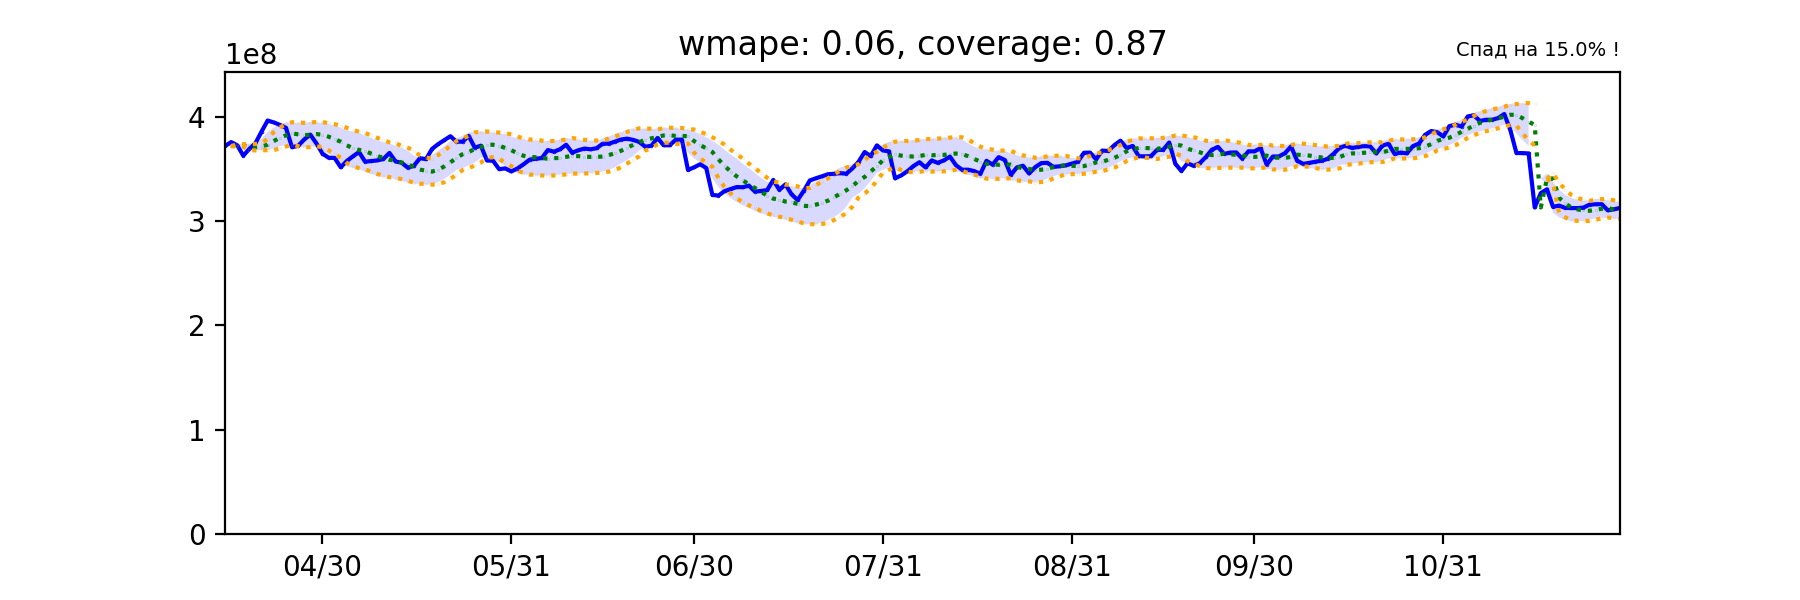

In [ ]:
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(111)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
date_format = "%Y-%m-%d"

start_date, end_date = '2021-01-05' , '2021-12-30'
max_points = len(df[start_date: end_date]) - 2
days_forecast = 7*4
days_before_init = 4*7

# replica = '/data/core/internal/athena_cur'
# replica = '/data/core/internal/crm_rb2'
replica = '/data/core/internal/EKS'
# replica = '/data/core/ods/039_000003'
# replica = '/data/core/internal/smartvista'
d = df[replica]

# Весь кластер :
d = np.sum(df, axis=1)

scope = Scope(df = d, 
              ax = ax,
              start_date = start_date,
              end_date = end_date,
              days_forecast = days_forecast,
              days_before_init = days_before_init, polinom_n = 1)
FuncAnimation(fig, scope.update, max_points, interval =10, repeat = False)